In [359]:
import numpy as np
import scipy as sp
from scipy.spatial import distance
class kEDMD:
    def __init__(self, X, Y, kernel="gaussian", **kwargs):
        """
        X: N_dim * M_data
        Y: N_dim * M_data
        """
        self.X = X
        self.Y = Y
        self.kernel = kernel
        
        if self.kernel == "gaussian":
            assert "eps" in kwargs, "gaussian kernel needs eps param"
            self.eps = kwargs["eps"]
            self.f = self.gramian
        elif self.kernel == "polynomial":
            assert ("p" in kwargs) and ("c" in kwargs), "polynomial kernel needs c and p param"
            self.p = kwargs["p"]
            self.c = kwargs["c"]
            if "gamma" in kwargs:
                self.gamma = kwargs["gamma"]
            else:
                self.gamma = 1.0
            self.f = self.polynomial
        
    def fit(self, truncation=1e-3):
        
        self.G = self.f(self.X, self.X)
        self.A = self.f(self.X, self.Y)
        
        # 低ランク近似
        U, s, V = sp.linalg.svd(self.G)
        mask = s > truncation
        U = U[:, mask]
        V = V[mask, :]
        S_inv = np.diag(1/s[mask])
        # カーネルクープマン行列を求める
        self.K = V.T @ S_inv @ U.T @ self.A
        self.calc_modes(truncation=truncation)
        return None
        
    def calc_modes(self, truncation=1e-3):
        # 固有値,固有ベクトルを求める
        self.eigenvalues, self.eigenvectors = sp.linalg.eig(self.K)

        # Kを求めるときに使った各データ点x1, x2, ..., xMを用いて，固有関数の値を求める
        # Gは対称行列なので下のコードのように転置を取らなくても良い
        # 低ランク近似（必要に応じて、必要なければtruncation=0にすれば良い）
        self.modes = sp.linalg.pinv(self.G.T @ self.eigenvectors, rtol=truncation) @ self.X.T
        return None

    def calc_eigenfunction(self, x):
        M = self.X.shape[1] # num_data
        self.eigenfuncion = np.zeros([M])
        
        #次の座標を予測したいデータ点を入力とする固有関数の値を求める
        if self.kernel == "gaussian":
            phi_Xx = np.exp(-np.linalg.norm(X - x, axis=0)**2/(2*(self.eps**2))) @ self.eigenvectors
        elif self.kernel == "polynomial":
            phi_Xx = (self.c + x.T @ self.X)**self.p @ self.eigenvectors
        return phi_Xx
        
    def predict(self, x):
        """
        x: 1 * N_dim
        return: 1 * N_dim
        """
        phi_Xx = self.calc_eigenfunction(x)
        return np.real((self.eigenvalues * phi_Xx.flatten()) @ self.modes).T

    def gramian(self, X, Y):
        return np.exp(-distance.cdist(X.T, Y.T, 'sqeuclidean')/(2*(self.eps**2)))
         
    def polynomial(self, X, Y):
        """
        c: param
        d: order
        X: D * M次元
        Y: D * M次元
        return Gram matrix, each element = k(x_i, y_i)
        """
        M = X.shape[1]
        G = np.zeros([M, M])
        for i in range(M):
            for j in range(M):
                G[i, j] += (self.gamma*(Y[:, i].T @X[:, j]) + self.c)**self.p
        return G

def svd_update(U, s, V, a, b):
    m = U.T @ a
    n = V @ b
    p = a - U @ m
    q = b - V.T @ n
    Ra = np.linalg.norm(p)
    Rb = np.linalg.norm(q)
    P = p/Ra
    Q = q/Rb
    
    K = np.append(m, Ra).reshape(-1,1) @ np.append(n, Rb).reshape(-1,1).T
    K[:-1, :-1] += np.diag(s)
    U_prime, s_prime, V_prime = np.linalg.svd(K)
    UpdatedU = np.hstack([U, P]) @ U_prime
    UpdatedV = np.hstack([V.T, Q]) @ V_prime.T
    
    return UpdatedU, s_prime, UpdatedV.T

def polynomial_kernel(X, Y, gamma=1, d=5, c=1):
    """
    X: D * M次元
    Y: D * M次元
    return Gram matrix, each element = k(x_i, y_i)
    """
    M = X.shape[1]
    G = np.zeros([M, M])
    for i in range(M):
        for j in range(M):
            G[i, j] += (gamma*(Y[:, i].T @X[:, j]) + c)**d
    return G

In [309]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


def lorentz(t, x, sigma, rho, beta):
    dx0dt = sigma * (x[1] - x[0])
    dx1dt = rho * x[0] - x[1] - x[0]*x[2]
    dx2dt = x[0] * x[1] - beta * x[2]
    return [dx0dt, dx1dt, dx2dt]

time_step = [0, 5]
sigma = 10
rho = 28
beta = 8
np.random.seed(100)
initial_value = np.random.uniform(low=-15, high=15, size=3)
print(initial_value)
sol_lorentz = solve_ivp(lorentz, t_span=time_step, y0=initial_value, args=[sigma, rho, beta], rtol=1e-8, t_eval=np.arange(0, 5, 0.01))
solution_lorentz = (sol_lorentz.y - np.min(sol_lorentz.y, axis=1).reshape(-1, 1)) / (np.max(sol_lorentz.y, axis=1) - np.min(sol_lorentz.y, axis=1)).reshape(-1,1)
initial_value = (initial_value.reshape(-1,1) - np.min(sol_lorentz.y, axis=1).reshape(-1, 1)) / (np.max(sol_lorentz.y, axis=1) - np.min(sol_lorentz.y, axis=1)).reshape(-1,1)

x = solution_lorentz[0]
y = solution_lorentz[1]
z = solution_lorentz[2]
X_lorentz = solution_lorentz[:, :-1]
Y_lorentz = solution_lorentz[:, 1:]
print("done")

[ 1.30214825 -6.64891845 -2.26447228]
done


In [360]:
# kernel EDMD
# 閾値

# カーネルKoopman行列を求める
#K_kernel = sp.linalg.inv((G_hat + c*np.eye(M,M))) @ A_hat
kedmd = kEDMD(X_lorentz, Y_lorentz, kernel="polynomial", p=10, c=1)
kedmd.fit(truncation=1e-5)

# 予測値を求める
pred = []
print(X_lorentz.shape)
for x in X_lorentz.T:
    pred.append(kedmd.predict(x))
print("done")

(3, 499)
done


In [365]:
G_hat = polynomial_kernel(X_lorentz, X_lorentz, gamma=1.0, d=10, c=1)
A_hat = polynomial_kernel(X_lorentz, Y_lorentz, gamma=1.0, d=10, c=1)

# G_hatの低ランク近似
threshold = 1e-5
U, S, V = sp.linalg.svd(G_hat)
mask = S > threshold
U = U[:, mask]
V = V[mask, :]
S_inv = np.diag(1 / S[mask])
K_kernel = V.T @ S_inv @ U.T @ A_hat

# Koopman eigenvalue, vector
d_kernel, V_kernel = sp.linalg.eig(K_kernel)
eigf_x = G_hat.T @ V_kernel
# モードを求める
modes_data = sp.linalg.pinv(eigf_x, rtol=1e-5) @ X_lorentz.T
y_kedmd =  np.real((d_kernel * eigf_x) @ modes_data).T
error_kedmd = np.linalg.norm(y_kedmd - Y_lorentz, axis=0).mean()

-1.6404285975765038e-11


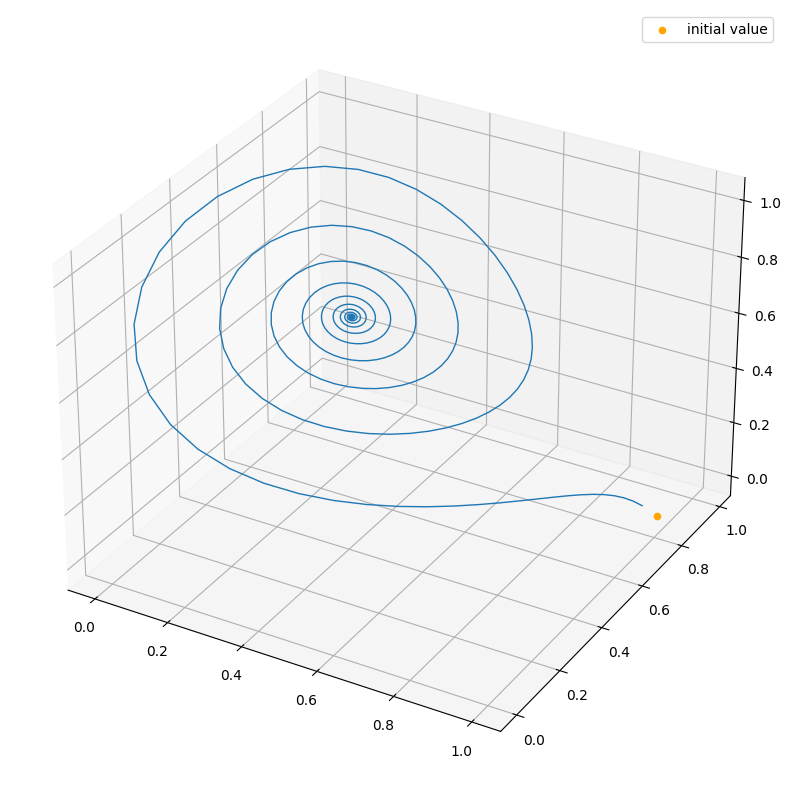

In [368]:
#y_kedmd = np.real((kedmd.eigenvalues * kedmd.eigenfunction) @ kedmd.modes).T
#y_kedmd = np.array(pred).T
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(initial_value[0], initial_value[1],initial_value[2], color="orange", label="initial value")
# ax.set_xlabel("x", fontsize=10)
# ax.set_ylabel("y", fontsize=10)
# ax.set_zlabel("z", fontsize=10)
#ax.set_title("kEDMD prediction, n_data={}".format(G_hat.shape[0]), fontsize=10)
ax.plot(y_kedmd[0], y_kedmd[1], y_kedmd[2], linewidth=1)
plt.legend(loc="upper right", fontsize=10)
plt.show()